# Importing Libraries

In [1]:
import os
import torch
import random
import torchvision
import numpy as np
from torch import nn
from PIL import Image
from parse import parse
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Hyper Parameters

In [2]:
# hyper params
num_of_class = 102
learning_rate = 1e-03
batch_size = 128
input_size = 224
device = torch.device("cuda")
test_size = 0.2
train_size = 0.7
val_size = 0.1
directoryAgeDB = 'AgeDB/'

## Transformation

In [3]:
train_transform = A.Compose([
    A.Resize(input_size, input_size),
    A.ToGray(p=1),
    A.Rotate(limit=20, p=1),
    A.HorizontalFlip(p=0.75),
    A.OneOf([
        A.Blur(blur_limit=3, p=1),
        A.OpticalDistortion(p=1),
    ], p=1),
    ToTensorV2()
])

test_transform = A.Compose([
     A.Resize(input_size, input_size),
     A.ToGray(p=1),
     ToTensorV2()
])

## Definition of Dataset and DataHandler

In [4]:
class AgeDBDataset(Dataset):
    
    def __init__(self, image_list, device, train=False, augment=1, train_transform=None, test_transform=None, **kwargs):
        self.image_list = image_list
        self.device = device
        self.train = train
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.labels = []
        self.images = []
        device = torch.device("cuda")

        if self.train:
            for i in tqdm(range(len(image_list))):

                image = Image.open(self.image_list[i]['image_location']).convert('RGB')
                image_location = self.image_list[i]['image_location']
                age = self.image_list[i]['age']
                gender = self.image_list[i]['gender']

                image = np.array(image)

                for j in range(augment):
                    if j == 0:
                        augmented_images = self.test_transform(image=image)['image']
                    else:
                        augmented_images = self.train_transform(image=image)['image']

                    self.images.append(augmented_images)
                    self.labels.append({
                        'image_location': image_location,
                        'age': age,
                        'gender': gender
                    })

                    
    def __len__(self):

        if self.train:
            return len(self.labels)
        else:
            return len(self.image_list)

        
    def __getitem__(self, index):

        if torch.is_tensor(index):
            index = index.tolist()

        if self.train:
            image = self.images[index]
            labels = {
                'image_location': self.labels[index]['image_location'],
                'age': self.labels[index]['age'],
                'gender': self.labels[index]['gender']
            }

        else:
            image = Image.open(
                self.image_list[index]['image_location']).convert('RGB')
            image = np.array(image)
            image = self.test_transform(image=image)['image']
            labels = {
                'image_location': self.image_list[index]['image_location'],
                'age': self.image_list[index]['age'],
                'gender': self.image_list[index]['gender']
            }

        return image.to(self.device), labels

In [5]:
class DataHandler():
    
    def __init__(self, test_size, val_size, train_size):
        self.test_size = test_size
        self.val_size = val_size
        self.train_size = train_size

        self.listofzeros = [0] * 102
        self.same_age = [i for i in range(0, 102)]
        self.theta1 = 0.998
        self.theta2 = 0.997


    def imageList(self, directory):
        self.directory = directory
        self.image_list = []
        for i, file in enumerate(sorted(os.listdir(self.directory))):
            file_labels = parse('{}_{}_{age}_{gender}.jpg', file)

            if file_labels is None:
                continue

            image_location = os.path.join(self.directory, file)
            gender_to_class_id = {'m': 0, 'f': 1}
            gender = gender_to_class_id[file_labels['gender']]
            age = int(file_labels['age'])
            self.image_list.append({
                'image_location': image_location,
                'age': age,
                'gender': gender
            })

        random.shuffle(self.image_list)
        return self.image_list  ###################


    def findAge(self):
        self.image_num_list = {}
        self.image_num_list = dict(zip(self.same_age, self.listofzeros))

        for i in range(len(self.image_list)):
            self.image_num_list[self.image_list[i]['age']] += 1

        return self.image_num_list  ##################


    def TestValTrainNum(self):
        self.num_test_imgs = {}
        self.num_val_imgs = {}
        self.num_train_imgs = {}

        self.num_test_imgs = dict(zip(self.same_age, self.listofzeros))
        self.num_val_imgs = dict(zip(self.same_age, self.listofzeros))
        self.num_train_imgs = dict(zip(self.same_age, self.listofzeros))

        for i in range(len(self.image_list)):
            self.num_train_imgs[self.image_list[i]['age']] += 1

        # For Test
        for i in range(len(self.image_num_list)):

            if self.num_train_imgs[i] != 0:

                if round(self.num_train_imgs[i] * self.test_size) <= 0:
                    self.num_test_imgs[i] = 1
                    self.num_train_imgs[i] -= 1

                else:
                    self.num_test_imgs[i] = round(self.image_num_list[i] * self.test_size * self.theta1)
                    self.num_train_imgs[i] = self.num_train_imgs[i] - self.num_test_imgs[i]

        # For Validation
        for i in range(len(self.image_num_list)):

            if self.num_train_imgs[i] != 0:

                if round(self.num_train_imgs[i] * self.val_size) <= 0:
                    self.num_val_imgs[i] = 1
                    self.num_train_imgs[i] -= 1

                else:
                    self.num_val_imgs[i] = round(self.image_num_list[i] * self.val_size * self.theta2)
                    self.num_train_imgs[i] = self.num_train_imgs[i] - self.num_val_imgs[i]

        # Test, Validation, Train
        return self.num_test_imgs, self.num_val_imgs, self.num_train_imgs  ##############


    def test_val_train_list(self):
        self.test_image_list = []
        self.validate_image_list = []
        self.train_image_list = []

        n_test_imgs = self.num_test_imgs.copy()
        n_val_imgs = self.num_val_imgs.copy()
        n_train_imgs = self.num_train_imgs.copy()

        for i in range(len(self.image_list)):

            if n_test_imgs[self.image_list[i]['age']] > 0:
                self.test_image_list.append(self.image_list[i])
                n_test_imgs[self.image_list[i]['age']] -= 1

            elif n_val_imgs[self.image_list[i]['age']] > 0:
                self.validate_image_list.append(self.image_list[i])
                n_val_imgs[self.image_list[i]['age']] -= 1

            else:
                self.train_image_list.append(self.image_list[i])
                n_train_imgs[self.image_list[i]['age']] -= 1

        return  self.train_image_list, self.test_image_list, self.validate_image_list  ##############

# Attributes

In [6]:
ageDBDataHandler = DataHandler(
    test_size = test_size,
    val_size = val_size,
    train_size = train_size,
)

ageDBDataHandler.imageList(directoryAgeDB)
ageDBDataHandler.findAge()
ageDBDataHandler.TestValTrainNum()
test_image_list, validate_image_list, train_image_list = ageDBDataHandler.test_val_train_list()

In [7]:
image_list = ageDBDataHandler.imageList(directoryAgeDB)

print(len(image_list))
print(image_list[0]['image_location'])
print(image_list[0]['age'])
print(image_list[0]['gender'])

16488
AgeDB/7478_PeterMarkRichman_60_m.jpg
60
0


In [8]:
num_test_imgs, num_val_imgs, num_train_imgs = ageDBDataHandler.TestValTrainNum()

In [9]:
def showSplit(image_list, image_num_list, num_test_imgs, num_val_imgs, num_train_imgs):
    visualsplit = {}
    visualsplit['Order'] = ['Test', 'Val', 'Train', 'Test%', 'Val%', 'Train%']

    for i in range(len(image_num_list)):
        visualsplit[i] = [num_test_imgs[i], num_val_imgs[i], num_train_imgs[i]]

    for i in range(len(image_num_list)):

        if num_test_imgs[i] == 0 or num_val_imgs == 0 or num_train_imgs == 0:
            visualsplit[i].append([0, 0, 0])
        else:
            visualsplit[i].append([
                round((num_test_imgs[i] / image_num_list[i] * 100), 1),
                round((num_val_imgs[i] / image_num_list[i] * 100), 1),
                round((num_train_imgs[i] / image_num_list[i] * 100), 1),
            ])

    show = f' Test = {sum(num_test_imgs.values()) / len(image_list) * 100 :.4f} % \
           \n  Val = {sum(num_val_imgs.values()) / len(image_list) * 100 :.4f} % \
           \nTrain = {sum(num_train_imgs.values()) / len(image_list) * 100 :.4f} %'

    print(show, '\n')
    return visualsplit

# Class samples in Train, Test and Validation set

In [10]:
image_num_list = ageDBDataHandler.findAge()
showSplit(image_list, image_num_list, num_test_imgs, num_val_imgs, num_train_imgs)

 Test = 20.0024 %            
  Val = 10.0012 %            
Train = 69.9964 % 



{'Order': ['Test', 'Val', 'Train', 'Test%', 'Val%', 'Train%'],
 0: [0, 0, 0, [0, 0, 0]],
 1: [1, 0, 0, [100.0, 0.0, 0.0]],
 2: [0, 0, 0, [0, 0, 0]],
 3: [2, 1, 5, [25.0, 12.5, 62.5]],
 4: [1, 1, 0, [50.0, 50.0, 0.0]],
 5: [1, 1, 2, [25.0, 25.0, 50.0]],
 6: [2, 1, 5, [25.0, 12.5, 62.5]],
 7: [2, 1, 8, [18.2, 9.1, 72.7]],
 8: [2, 1, 5, [25.0, 12.5, 62.5]],
 9: [1, 1, 4, [16.7, 16.7, 66.7]],
 10: [3, 1, 9, [23.1, 7.7, 69.2]],
 11: [4, 2, 14, [20.0, 10.0, 70.0]],
 12: [3, 1, 10, [21.4, 7.1, 71.4]],
 13: [4, 2, 16, [18.2, 9.1, 72.7]],
 14: [5, 2, 16, [21.7, 8.7, 69.6]],
 15: [9, 4, 30, [20.9, 9.3, 69.8]],
 16: [10, 5, 37, [19.2, 9.6, 71.2]],
 17: [16, 8, 58, [19.5, 9.8, 70.7]],
 18: [24, 12, 84, [20.0, 10.0, 70.0]],
 19: [22, 11, 77, [20.0, 10.0, 70.0]],
 20: [32, 16, 113, [19.9, 9.9, 70.2]],
 21: [33, 16, 114, [20.2, 9.8, 69.9]],
 22: [37, 18, 128, [20.2, 9.8, 69.9]],
 23: [42, 21, 149, [19.8, 9.9, 70.3]],
 24: [52, 26, 181, [20.1, 10.0, 69.9]],
 25: [57, 28, 199, [20.1, 9.9, 70.1]],
 26: 

In [11]:
train_image_list, test_image_list, validate_image_list = ageDBDataHandler.test_val_train_list()

In [12]:
print('Train Set Length:      ', len(train_image_list))
print('Test Set Length:       ', len(test_image_list))
print('Validation Set Length: ', len(validate_image_list))
print('Total Length: ', (len(train_image_list)+len(test_image_list)+len(validate_image_list)))

Train Set Length:       11541
Test Set Length:        3298
Validation Set Length:  1649
Total Length:  16488


In [13]:
def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    if torch.is_tensor(image):
        image = np.squeeze(image)
        plt.imshow(image.permute(1, 2, 0))
    else:
        plt.imshow(image)

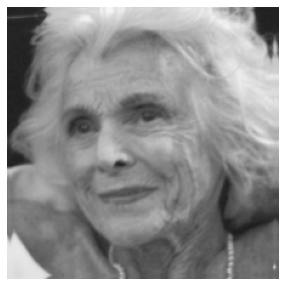

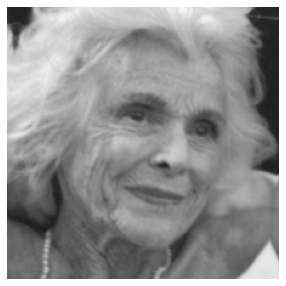

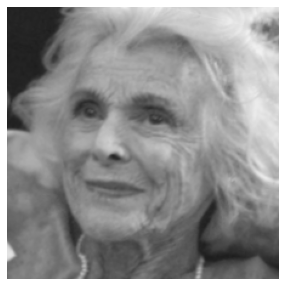

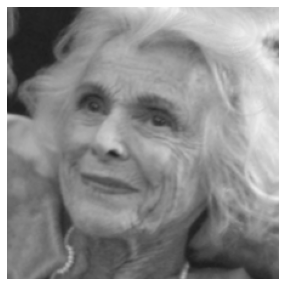

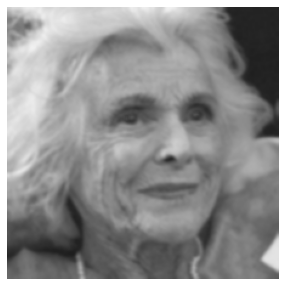

In [14]:
visualize_image = Image.open(train_image_list[0]['image_location'])
image = np.array(
    visualize_image)  # Py = delete , Albu = image = np.array(image)
for i in range(5):
    augmented_images = train_transform(image=image)['image']
    visualize(augmented_images)

In [15]:
trainDataset = AgeDBDataset(image_list=train_image_list,
                                device=device,
                                train=True,
                                train_transform=train_transform,
                                test_transform=test_transform)

testDataset = AgeDBDataset(image_list=test_image_list,
                               device=device,
                               train=False,
                               train_transform=train_transform,
                               test_transform=test_transform)

valDataset = AgeDBDataset(image_list=validate_image_list,
                              device=device,
                              train=False,
                              train_transform=train_transform,
                              test_transform=test_transform)


train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(valDataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/11541 [00:00<?, ?it/s]

# Dataset Attributes

In [16]:
datasetlist = train_image_list+test_image_list+validate_image_list
dataset = AgeDBDataset(image_list=datasetlist,
                              device=device,
                              train=False,
                              train_transform=train_transform,
                              test_transform=test_transform)


In [17]:
len(dataset)

16488

In [18]:
dataset[0]

(tensor([[[ 69,  70,  70,  ...,  75,  75,  78],
          [ 37,  39,  40,  ...,  46,  47,  49],
          [ 34,  37,  38,  ...,  40,  40,  43],
          ...,
          [235, 234, 231,  ..., 215, 214, 213],
          [237, 234, 231,  ..., 214, 214, 214],
          [238, 235, 232,  ..., 214, 214, 213]],
 
         [[ 69,  70,  70,  ...,  75,  75,  78],
          [ 37,  39,  40,  ...,  46,  47,  49],
          [ 34,  37,  38,  ...,  40,  40,  43],
          ...,
          [235, 234, 231,  ..., 215, 214, 213],
          [237, 234, 231,  ..., 214, 214, 214],
          [238, 235, 232,  ..., 214, 214, 213]],
 
         [[ 69,  70,  70,  ...,  75,  75,  78],
          [ 37,  39,  40,  ...,  46,  47,  49],
          [ 34,  37,  38,  ...,  40,  40,  43],
          ...,
          [235, 234, 231,  ..., 215, 214, 213],
          [237, 234, 231,  ..., 214, 214, 214],
          [238, 235, 232,  ..., 214, 214, 213]]], device='cuda:0',
        dtype=torch.uint8),
 {'image_location': 'AgeDB/12615_Franc

In [19]:
dataset[27][1]['age']

63

In [20]:
dataset[35][1]['gender']

1

In [21]:
type(dataset)

__main__.AgeDBDataset

In [22]:
type(dataset[0])

tuple

In [23]:
age = []
gender = []
for i in range(len(dataset)):
    age.append(dataset[i][1]['age'])

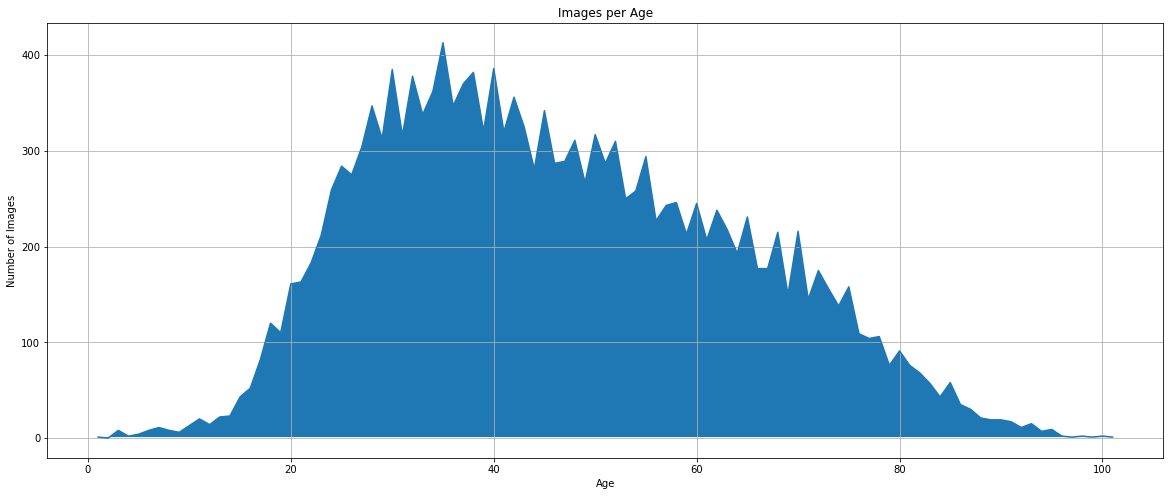

In [24]:
listofzeros = [0] * len(dataset)
same_age = [i for i in range(min(age), max(age) + 1)]
age_number = dict(zip(same_age, listofzeros))

for i in range(len(dataset)):
    if age[i] in age_number:
        age_number[age[i]] += 1

age_amount = age_number.items()
x, y = zip(*age_amount)

plt.figure(figsize = (20, 8))
plt.plot(x, y)
plt.fill(x, y)
plt.title("Images per Age")
plt.xlabel("Age")
plt.ylabel("Number of Images")
plt.grid()
plt.show()

In [25]:
age_number

{1: 1,
 2: 0,
 3: 8,
 4: 2,
 5: 4,
 6: 8,
 7: 11,
 8: 8,
 9: 6,
 10: 13,
 11: 20,
 12: 14,
 13: 22,
 14: 23,
 15: 43,
 16: 52,
 17: 82,
 18: 120,
 19: 110,
 20: 161,
 21: 163,
 22: 183,
 23: 212,
 24: 259,
 25: 284,
 26: 275,
 27: 304,
 28: 347,
 29: 313,
 30: 385,
 31: 316,
 32: 378,
 33: 338,
 34: 362,
 35: 413,
 36: 347,
 37: 370,
 38: 382,
 39: 321,
 40: 386,
 41: 320,
 42: 356,
 43: 325,
 44: 281,
 45: 342,
 46: 287,
 47: 289,
 48: 311,
 49: 267,
 50: 317,
 51: 287,
 52: 310,
 53: 250,
 54: 258,
 55: 294,
 56: 227,
 57: 243,
 58: 246,
 59: 213,
 60: 245,
 61: 207,
 62: 238,
 63: 218,
 64: 193,
 65: 231,
 66: 177,
 67: 177,
 68: 215,
 69: 150,
 70: 216,
 71: 145,
 72: 175,
 73: 156,
 74: 138,
 75: 158,
 76: 109,
 77: 104,
 78: 106,
 79: 76,
 80: 91,
 81: 76,
 82: 68,
 83: 57,
 84: 43,
 85: 58,
 86: 35,
 87: 30,
 88: 21,
 89: 19,
 90: 19,
 91: 17,
 92: 11,
 93: 15,
 94: 7,
 95: 9,
 96: 2,
 97: 1,
 98: 2,
 99: 1,
 100: 2,
 101: 1}

# Split Dataset

In [26]:
def findAge(image_list):
    listofzeros = [0] * 102
    same_age = [i for i in range(0, 102)]
    age_number = dict(zip(same_age, listofzeros))

    for i in range(len(image_list)):
        age_number[image_list[i]['age']] += 1

    return age_number

In [27]:
def plotTTage(train_image_list, test_image_list, validate_image_list):
    #plot 1:
    train_age = findAge(train_image_list).items()
    x1, y1 = zip(*train_age)

    #plot 2:
    test_age = findAge(test_image_list).items()
    x2, y2 = zip(*test_age)

    #plot 3:
    val_age = findAge(validate_image_list).items()
    x3, y3 = zip(*val_age)
    
    
    plt.figure(figsize = (20, 8))
    plt.plot(x1, y1)
    plt.fill(x1, y1)
    plt.plot(x2, y2)
    plt.fill(x2, y2)
    plt.plot(x3, y3)
    plt.fill(x3, y3)

    plt.legend(["Train", "Test", "Validation"])

    plt.title("Data Distribution")
    plt.xlabel("Age")
    plt.ylabel("Number of Images")
    plt.grid()
    plt.show()

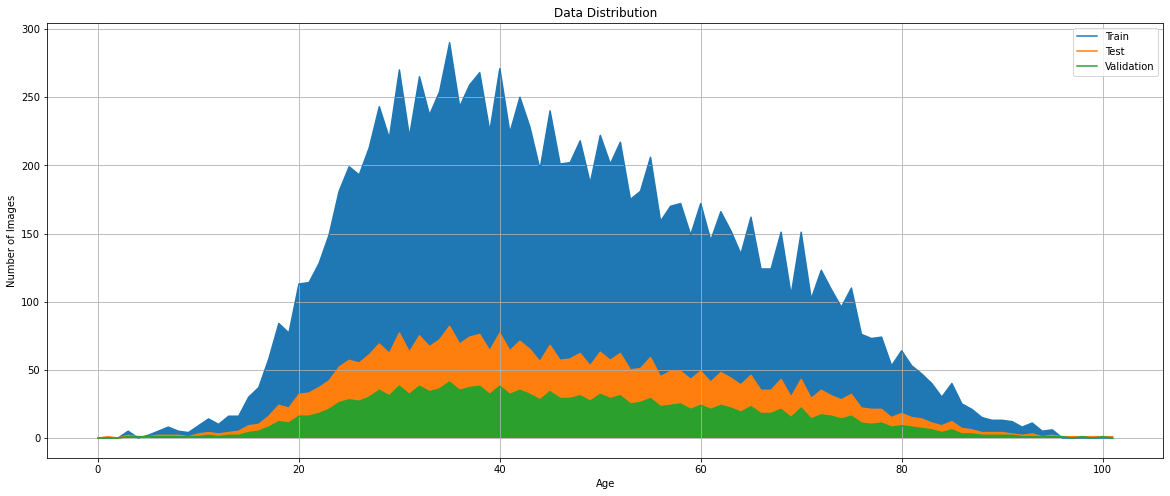

In [28]:
plotTTage(train_image_list, test_image_list, validate_image_list)